# Toxic Comments Dataset Exploration

This notebook explores the Jigsaw Toxic Comments dataset, analyzing its characteristics and preparing it for model training.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configure visualizations
# plt.style.use('seaborn')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = [12, 6]

## 1. Data Loading and Initial Inspection

In [2]:
# Load the dataset
df = pd.read_csv('../data/train.csv')

# Basic information
print("Dataset Shape:", df.shape)
print("\nColumns:", df.columns.tolist())
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

# Display first few rows
print("\nFirst few rows:")
df.head()

Dataset Shape: (159571, 8)

Columns: ['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

Data Types:
id               object
comment_text     object
toxic             int64
severe_toxic      int64
obscene           int64
threat            int64
insult            int64
identity_hate     int64
dtype: object

Missing Values:
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

First few rows:


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [21]:
import random

def get_random_train_example(df):
    """
    Returns a random entry from the training dataset with its corresponding label.
    
    Returns:
        tuple: (text, label) where text is the input text and label is its corresponding class
    """
    random_idx = random.randint(0, len(df) - 1)
    random_row = df.iloc[random_idx]
    text = random_row['comment_text']
    
    # browse through the label columns and print the label that is true
    for label in df.columns:
        if random_row[label] == 1:
            moderation = label
            break
    else:
        moderation = 'none'

    return text, moderation

text, moderation = get_random_train_example(df)
print(text)
print(moderation)


"

 Hey donkey 

Hey donkey, your Dad is coming.  — Preceding unsigned comment added by 117.196.229.56   

 Enjoying the creepy messages? 

Enjoying all these creepy messages son?  — Preceding unsigned comment added by 117.196.229.56   "
toxic


## 2. Label Distribution Analysis

Percentage of comments in each category:
toxic: 9.58%
severe_toxic: 1.00%
obscene: 5.29%
threat: 0.30%
insult: 4.94%
identity_hate: 0.88%


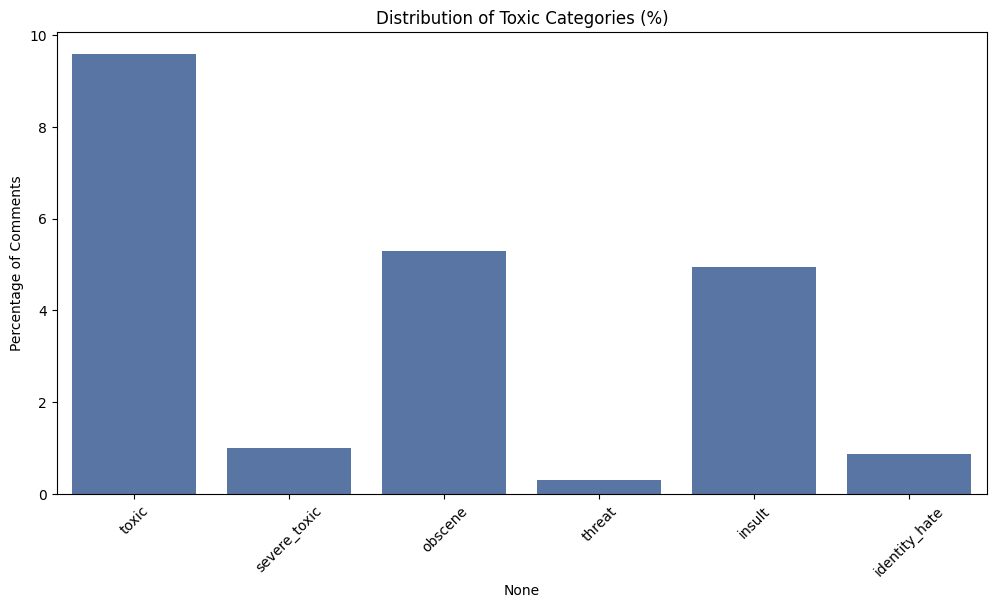

In [4]:
# Define toxic categories
toxic_columns = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Calculate and plot label distributions
label_dist = df[toxic_columns].sum() / len(df) * 100

plt.figure(figsize=(12, 6))
sns.barplot(x=label_dist.index, y=label_dist.values)
plt.title('Distribution of Toxic Categories (%)')
plt.xticks(rotation=45)
plt.ylabel('Percentage of Comments')

# Print exact percentages
print("Percentage of comments in each category:")
for category, percentage in label_dist.items():
    print(f"{category}: {percentage:.2f}%")

## 3. Text Length Analysis

Text length statistics:
         char_length     word_count
count  159571.000000  159571.000000
mean      394.073221      67.273527
std       590.720282      99.230702
min         6.000000       1.000000
25%        96.000000      17.000000
50%       205.000000      36.000000
75%       435.000000      75.000000
max      5000.000000    1411.000000


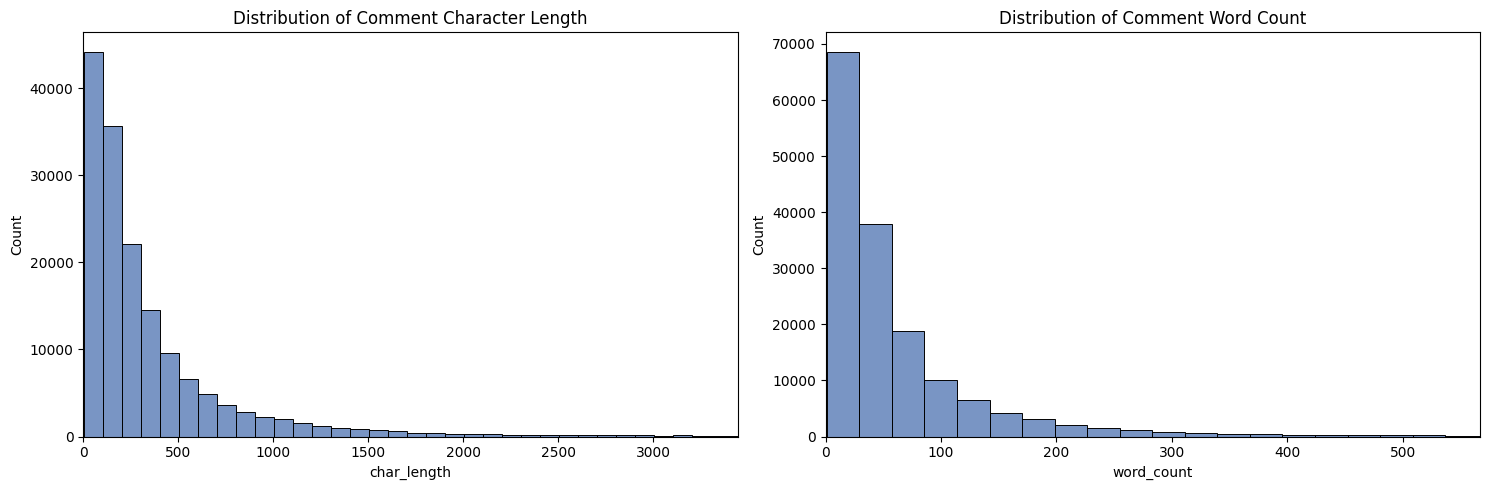

In [5]:
# Add text length features
df['char_length'] = df['comment_text'].str.len()
df['word_count'] = df['comment_text'].str.split().str.len()

# Plot distributions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

sns.histplot(data=df, x='char_length', bins=50, ax=ax1)
ax1.set_title('Distribution of Comment Character Length')
ax1.set_xlim(0, df['char_length'].quantile(0.99))  # Limit to 99th percentile

sns.histplot(data=df, x='word_count', bins=50, ax=ax2)
ax2.set_title('Distribution of Comment Word Count')
ax2.set_xlim(0, df['word_count'].quantile(0.99))  # Limit to 99th percentile

plt.tight_layout()

# Print summary statistics
print("Text length statistics:")
print(df[['char_length', 'word_count']].describe())

## 4. Label Correlations

Top correlations between categories:
obscene - insult: 0.741
toxic - obscene: 0.677
toxic - insult: 0.648
severe_toxic - obscene: 0.403
severe_toxic - insult: 0.376


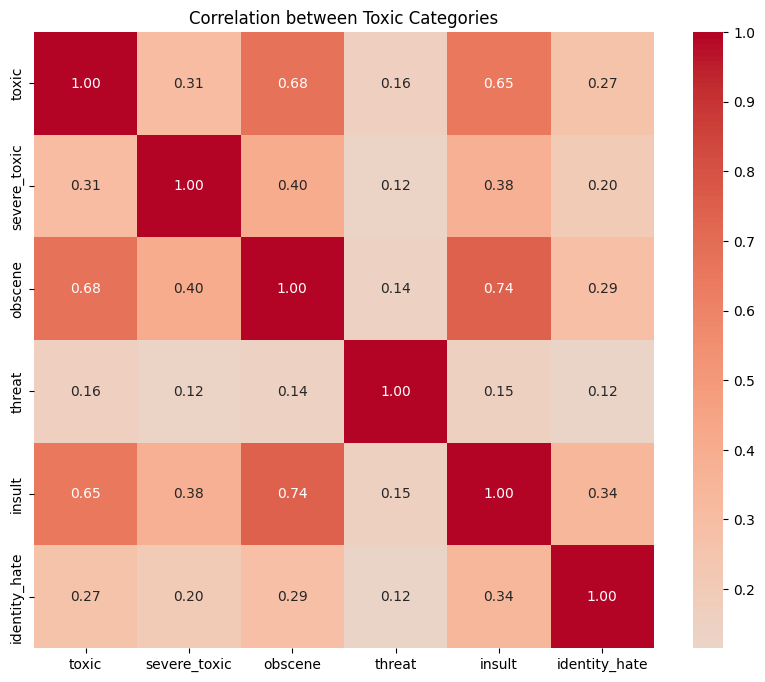

In [6]:
# Calculate and plot correlation matrix
corr_matrix = df[toxic_columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Correlation between Toxic Categories')

# Print strongest correlations
print("Top correlations between categories:")
correlations = []
for i in range(len(toxic_columns)):
    for j in range(i+1, len(toxic_columns)):
        correlations.append({
            'categories': f"{toxic_columns[i]} - {toxic_columns[j]}",
            'correlation': corr_matrix.iloc[i, j]
        })

correlations.sort(key=lambda x: abs(x['correlation']), reverse=True)
for corr in correlations[:5]:
    print(f"{corr['categories']}: {corr['correlation']:.3f}")

## 5. Text Cleaning and Preprocessing

In [7]:
import re

def clean_text(text):
    """Basic text cleaning function"""
    # Convert to lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '[URL]', text)
    
    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    
    # Replace multiple spaces with single space
    text = re.sub(r'\s+', ' ', text)
    
    return text.strip()

# Apply cleaning
df['clean_text'] = df['comment_text'].apply(clean_text)

# Show examples
print("Original vs Cleaned Text Examples:")
for orig, clean in zip(df['comment_text'].head(), df['clean_text'].head()):
    print(f"\nOriginal: {orig}\nCleaned:  {clean}\n---")

Original vs Cleaned Text Examples:

Original: Explanation
Why the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27
Cleaned:  explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.89.205.38.27
---

Original: D'aww! He matches this background colour I'm seemingly stuck with. Thanks.  (talk) 21:51, January 11, 2016 (UTC)
Cleaned:  d'aww! he matches this background colour i'm seemingly stuck with. thanks. (talk) 21:51, january 11, 2016 (utc)
---

Original: Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits inste

## 6. Feature Engineering

<>:4: SyntaxWarning: invalid escape sequence '\?'
<>:4: SyntaxWarning: invalid escape sequence '\?'
C:\Users\Nath\AppData\Local\Temp\ipykernel_10668\2661776960.py:4: SyntaxWarning: invalid escape sequence '\?'
  df['question_count'] = df['comment_text'].str.count('\?')


Average feature values for toxic vs non-toxic comments:
       caps_ratio  exclamation_count  question_count  special_chars  \
toxic                                                                 
0        0.044949           0.346784        0.434879      16.281590   
1        0.114575           3.631686        0.585131      14.448934   

       word_count  
toxic              
0       68.967874  
1       51.289787  


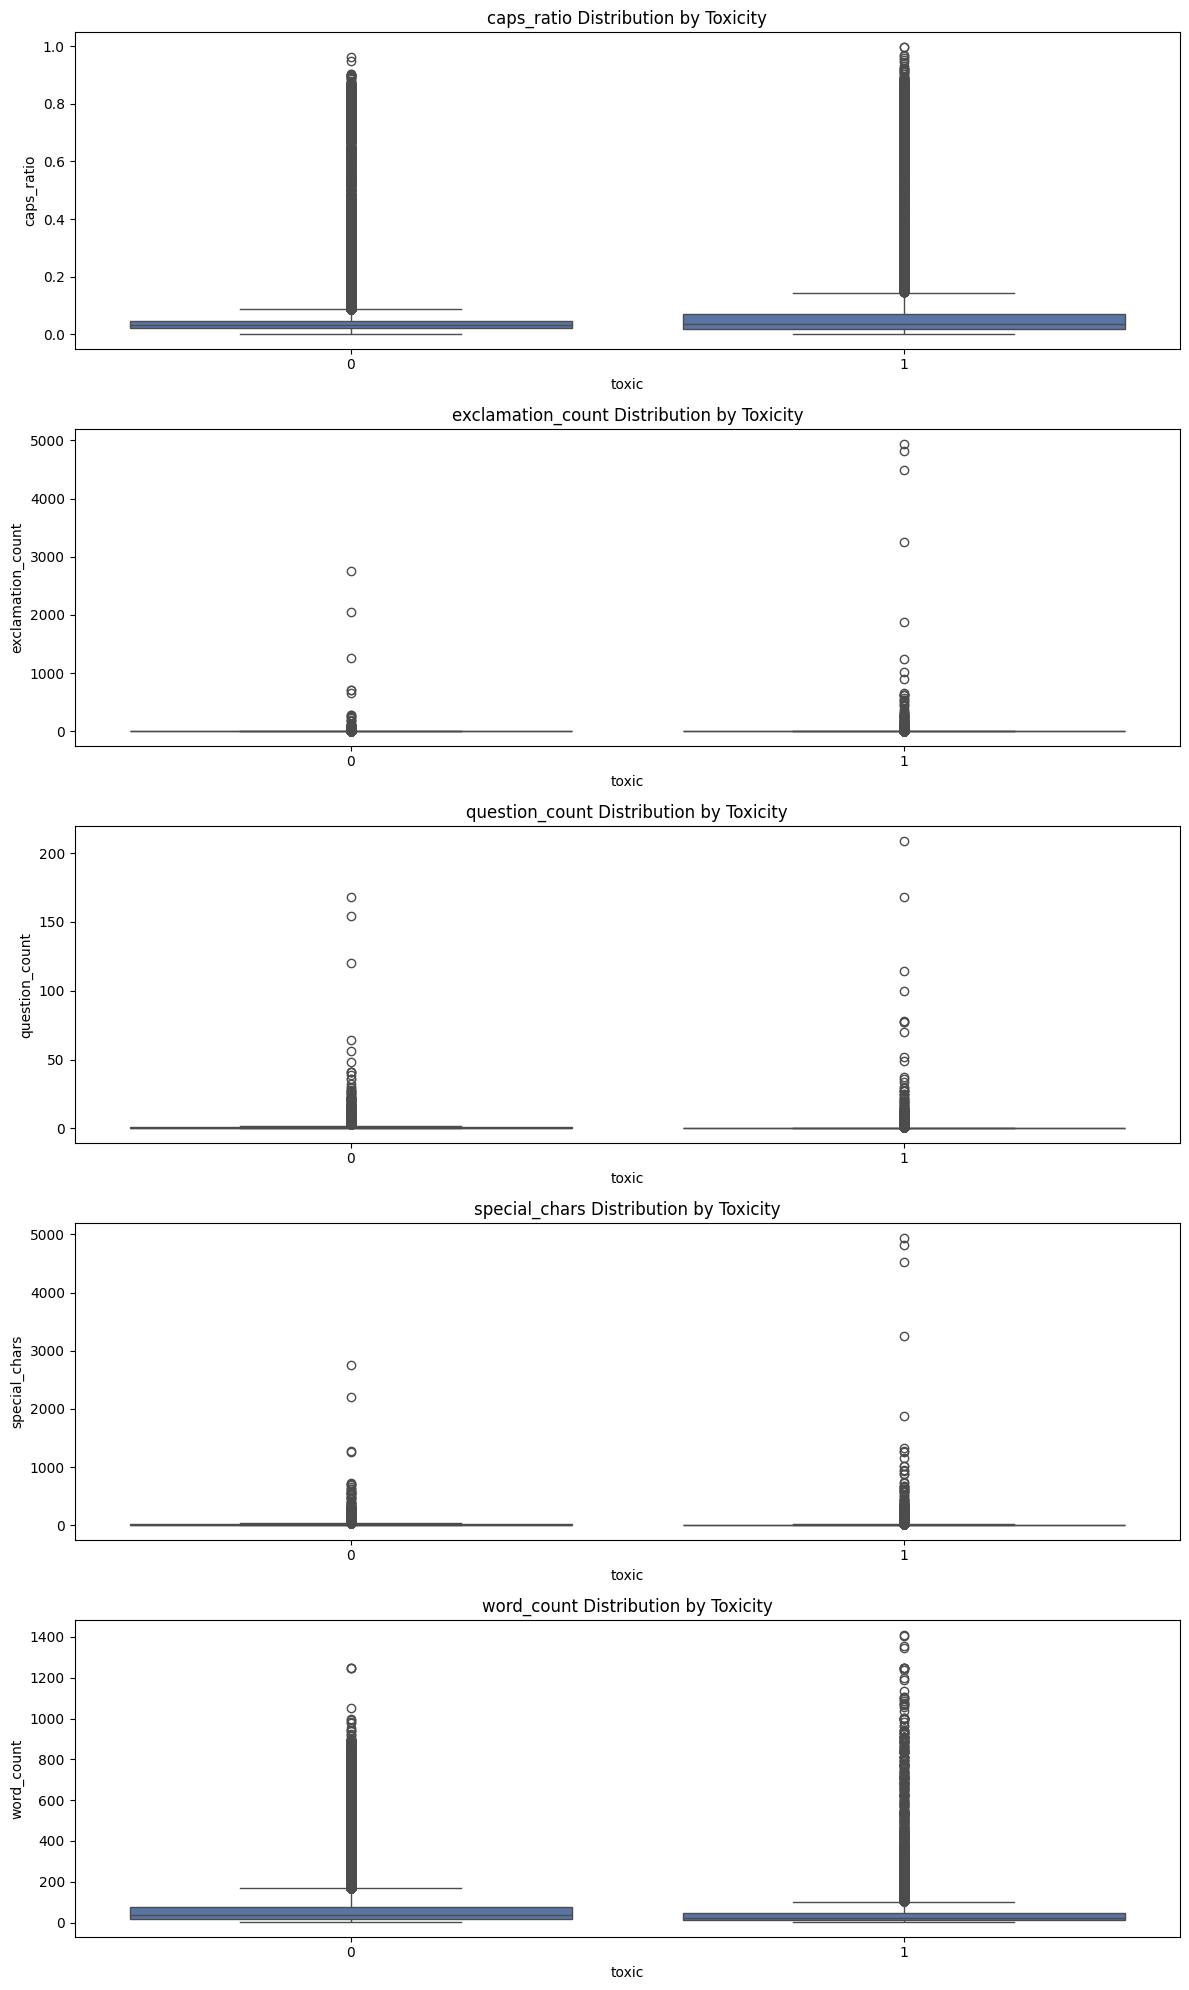

In [8]:
# Add text-based features
df['caps_ratio'] = df['comment_text'].apply(lambda x: sum(1 for c in x if c.isupper()) / len(x) if len(x) > 0 else 0)
df['exclamation_count'] = df['comment_text'].str.count('!')
df['question_count'] = df['comment_text'].str.count('\?')
df['special_chars'] = df['comment_text'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in x))

# Analyze features for toxic vs non-toxic comments
feature_cols = ['caps_ratio', 'exclamation_count', 'question_count', 'special_chars', 'word_count']

fig, axes = plt.subplots(len(feature_cols), 1, figsize=(12, 4*len(feature_cols)))
for i, feature in enumerate(feature_cols):
    sns.boxplot(data=df, x='toxic', y=feature, ax=axes[i])
    axes[i].set_title(f'{feature} Distribution by Toxicity')

plt.tight_layout()

# Print average values for toxic vs non-toxic
print("Average feature values for toxic vs non-toxic comments:")
print(df.groupby('toxic')[feature_cols].mean())

## 7. Multi-label Analysis

Distribution of comments by number of toxic labels:
0 labels: 143346 comments (89.83%)
1 labels: 6360 comments (3.99%)
2 labels: 3480 comments (2.18%)
3 labels: 4209 comments (2.64%)
4 labels: 1760 comments (1.10%)
5 labels: 385 comments (0.24%)
6 labels: 31 comments (0.02%)


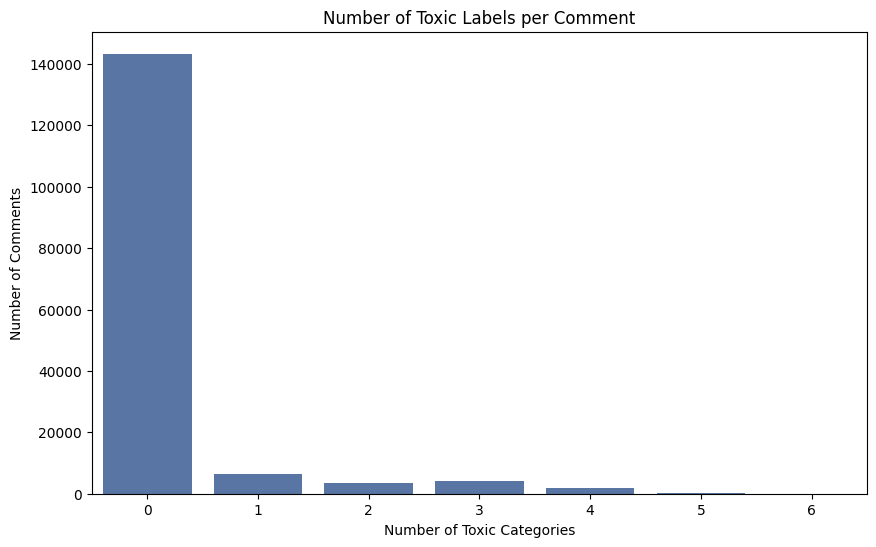

In [9]:
# Count number of toxic labels per comment
df['toxic_count'] = df[toxic_columns].sum(axis=1)

# Plot distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='toxic_count')
plt.title('Number of Toxic Labels per Comment')
plt.xlabel('Number of Toxic Categories')
plt.ylabel('Number of Comments')

# Print statistics
print("Distribution of comments by number of toxic labels:")
toxic_count_dist = df['toxic_count'].value_counts().sort_index()
for count, num_comments in toxic_count_dist.items():
    print(f"{count} labels: {num_comments} comments ({num_comments/len(df)*100:.2f}%)")

## 8. Preparing Data for Training

In [22]:
from sklearn.model_selection import train_test_split

# Prepare features and labels
X = df['clean_text']
y = df[toxic_columns]

# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42, stratify=df['toxic_count'])

# Save processed data
train_df = pd.DataFrame({
    'text': X_train,
    **y_train
})
train_df.to_csv('../data/processed_train.csv', index=False)

val_df = pd.DataFrame({
    'text': X_val,
    **y_val
})
val_df.to_csv('../data/processed_val.csv', index=False)

print("Data split sizes:")
print(f"Training set: {len(X_train)} samples")
print(f"Validation set: {len(X_val)} samples")

# Verify label distribution in splits
print("\nLabel distribution in splits:")
train_dist = y_train.mean()
val_dist = y_val.mean()

for col in toxic_columns:
    print(f"\n{col}:")
    print(f"  Train: {train_dist[col]*100:.2f}%")
    print(f"  Val: {val_dist[col]*100:.2f}%")

Data split sizes:
Training set: 143613 samples
Validation set: 15958 samples

Label distribution in splits:

toxic:
  Train: 9.58%
  Val: 9.66%

severe_toxic:
  Train: 1.00%
  Val: 1.02%

obscene:
  Train: 5.31%
  Val: 5.20%

threat:
  Train: 0.30%
  Val: 0.33%

insult:
  Train: 4.94%
  Val: 4.91%

identity_hate:
  Train: 0.88%
  Val: 0.89%
